# Paramap Analysis: Basic selection & flattening

    Document Date: 2021/02/22
    Author(s): Caglar Kutlu (caglar.kutlu@gmail.com)

## 1. About
Paramap is a gain exploration measurement for JPAs, currently only for 3-wave-mixing mode.  A single paramap measurement is performed by _fixing_ the bias current ($ i_b $), and sweeping pump frequency ($ f_p $) and pump power ($ p_p $).  This document deals with paramap the way they are measured using `groundcontrol` in the QNLA team at CAPP.

The gain is measured mainly at 2 select frequency offsets from $ f_p/2 $, `frequency_offset_1 (fo1)` and `frequency_offset_2 (fo2)`.   The measured gains for these two frequencies are referenced as `g1` and `g2` respectively.
The script `paramap.py` located under `groundcontrol/scripts`, performs paramap measurements at user provided set of $ i_b $s.  The script has option to do two additional gain measurements `g1m` and `g2m` at the _mirror_ frequencies of `fo1` and `fo2`, i.e. `-fo1` and `-fo2`.  The variables of interest can be simply described as:

$$
\verb|g1| \equiv G(f=f_p/2 + \verb|fo1|; i_b, f_p, p_p) \\
\verb|g2| \equiv G(f=f_p/2 + \verb|fo2|; i_b, f_p, p_p) \\
\verb|g1m| \equiv G(f=f_p/2 - \verb|fo1|; i_b, f_p, p_p) \\
\verb|g2m| \equiv G(f=f_p/2 - \verb|fo2|; i_b, f_p, p_p) \\
$$

As the experimenter is usually involved with measuring JPAs with completely different center frequencies, defining sweep ranges based on absolute pump frequency _quickly_ becomes cumbersome.  For this, an auxiliary variable named _normalized detuning_ is used instead.  I will omit saying _normalized_ and just refer to it as `detuning` from here on.  It is defined as:

$$
\delta' = \frac{f_p/2 - f_r}{\Gamma_0}
$$
where $ \Gamma_0 $ is simply $ \frac{\verb|PASSIVE BANDWIDTH|}{2}$, $f_r$ is passive resonance frequency and $ f_p $ is the pump frequency.  The `paramap.py` user gives minimum, maximum and step values to describe a set of detunings, the script calculates pump frequencies using $ f_p = 2(\Gamma_0 \delta' + f_r )$.  $ f_r $ and $ \Gamma_0 $ are also estimated through a passive resonance measurement performed by `paramap.py`.


## 2. Data
The original dataset saved by the `paramap.py` tries to record as much information as possible about the measurements.  A typical `paramap.py` output folder structure using a CSV backend is:

    JPA1.15G_PARAMAP
    ├── settings.json
    ├── PMSP
    │   ├── PMSP_EXP-i0_1.csv
    │   ├── PMSP_EXP-i1_8823.csv
    │   ├── PMSP_EXP-i2_17645.csv
    │   ├── PMSP_EXP-i3_26467.csv
    │   ├── .
    │   ├── .
    │   ├── .
    │   ├── PMSP_EXP-i37_326415.csv
    │   └── PMSP_EXP-i38_335237.csv
    ├── SPPM
    │   ├── SPPM_RES-i0_0.csv
    │   ├── SPPM_RES-i1_8822.csv
    │   ├── SPPM_RES-i2_17644.csv
    │   ├── SPPM_RES-i3_26466.csv
    │   ├── .
    │   ├── .
    │   ├── .
    │   ├── SPPM_RES-i37_326414.csv
    │   └── SPPM_RES-i38_335236.csv
    ├── PMR
    │   ├── PMR-AP_EXP-i0_2.csv
    │   ├── PMR-AP_EXP-i1_8824.csv
    │   ├── PMR-AP_EXP-i2_17646.csv
    │   ├── PMR-AP_EXP-i3_26468.csv
    │   ├── .
    │   ├── .
    │   ├── .
    │   ├── PMR-AP_EXP-i37_326416.csv
    │   └── PMR-AP_EXP-i38_335238.csv
    ├── groundcontrol.log
    ├── measurements.index
    └── paramap.py

The `paramap2netcdf.py` located under `groundcontrol/scripts/analysis` conveniently converts this measurement data into a common `netCDF4` file format (`.nc`).  This document only deals with the `.nc` file produced by `paramap2netcdf.py`. I will use `xarray` to show basic manipulation of the data.  You do not neet to know anything about the specifics of the netCDF4 format, nor details of the `xarray` library to follow this tutorial.

`xarray` is a tool for manipulating labeled data using numpy, matplotlib, etc. under the hood.  This is not aimed to be a tutorial for `xarray`.
[Here](https://medium.com/pangeo/thoughts-on-the-state-of-xarray-within-the-broader-scientific-python-ecosystem-5cee3c59cd2b) is short article promoting xarray.  For a formal introduction of the library, check out  http://xarray.pydata.org/en/stable/.

### 2.1 Reading Dataset

In [1]:
import xarray as xr  # For reading, processing and plotting data in .nc files

ncpath = "data/JPA1.15G_PARAMAP.nc"
ds = xr.open_dataset(ncpath)
display(ds)

<xarray.Dataset>
Dimensions:   (detuning: 45, ib: 39, ppump: 196)
Coordinates:
  * detuning  (detuning) float64 -2.2 -2.1 -2.0 -1.9 -1.8 ... 1.9 2.0 2.1 2.2
  * ppump     (ppump) float64 -20.0 -19.8 -19.6 -19.4 ... 18.4 18.6 18.8 19.0
  * ib        (ib) float64 -2.517e-05 -2.512e-05 ... -1.307e-05 -1.035e-05
    fr0       (ib) float64 ...
    bw0       (ib) float64 ...
Data variables:
    g1        (ib, ppump, detuning) float64 ...
    g2        (ib, ppump, detuning) float64 ...
    g1m       (ib, ppump, detuning) float64 ...
    g2m       (ib, ppump, detuning) float64 ...
Attributes:
    fo1:      1000.0
    fo2:      100000.0
    ps:       -20.0

As we can see there are 3 dimensions labeled 'detuning', 'ppump' (pump power), 'ib' (coil current).  These three dimensions have their associated coordinates.  

### 2.2 Preparing the Dataset

The pump frequencies are not saved in the dataset since it's completely determined by fr0 and detuning.  We can add a new coordinate for pump frequencies, following detuning and fr0 into the dataset, using $ f_p = 2(\Gamma_0 \delta' + f_r )$:

In [2]:
ds.coords['fp'] = 2*(ds.detuning*ds.bw0/2 + ds.fr0)

As of today, the `paramap2netcdf.py` does not provide descriptive names and units for the variables in the netcdf files unfortunately.  The units and descriptions however always recorded in the raw dataset.  Let's just embed some of the units into the dataset:

In [5]:
def setunits(da, unit: str):
     da.attrs['units'] = unit

setunits(ds.ppump, "dBm")

# Converting to uA
if ds.ib.attrs.get('units', '') != "$\mu $A":
    ds.coords['ib'] = ds.ib/1e-6
    setunits(ds.ib, "$\mu$A")

setunits(ds.fr0, "Hz")
setunits(ds.g1, "dB")
setunits(ds.g2, "dB")

Let's plot fr0 versus ib.:

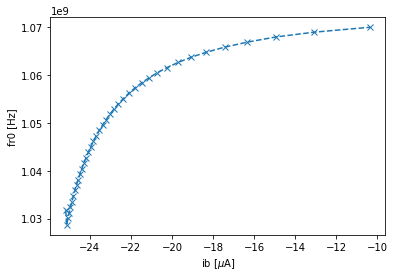

In [7]:
ds.fr0.plot(marker='x', linestyle='--')

We can see 'fr0' follows smoothly 'ib' except for the first measurement.  Usually the paramap measurements are performed for currents that stay on only one side of the $i_b$ - $f_r$ curve.  This means $ f_r $ is most likely a monotonic function of $ i_b $ and can be swapped with $ i_b $ as a dimension without loss of information.

In [8]:
dss = ds.swap_dims({'ib': 'fr0'})
display(dss)

<xarray.Dataset>
Dimensions:   (detuning: 45, fr0: 39, ppump: 196)
Coordinates:
  * detuning  (detuning) float64 -2.2 -2.1 -2.0 -1.9 -1.8 ... 1.9 2.0 2.1 2.2
  * ppump     (ppump) float64 -20.0 -19.8 -19.6 -19.4 ... 18.4 18.6 18.8 19.0
    ib        (fr0) float64 -25.17 -25.12 -25.06 -25.01 ... -14.93 -13.07 -10.35
  * fr0       (fr0) float64 1.032e+09 1.029e+09 1.03e+09 ... 1.069e+09 1.07e+09
    bw0       (fr0) float64 2.165e+06 2.029e+06 2.058e+06 ... 2.65e+06 2.693e+06
    fp        (detuning, fr0) float64 2.059e+09 2.053e+09 ... 2.146e+09
Data variables:
    g1        (fr0, ppump, detuning) float64 ...
    g2        (fr0, ppump, detuning) float64 ...
    g1m       (fr0, ppump, detuning) float64 ...
    g2m       (fr0, ppump, detuning) float64 ...
Attributes:
    fo1:      1000.0
    fo2:      100000.0
    ps:       -20.0

Since 'fr0' is a dimension now, we can select data nearest to the particular value of 'fr0':

In [9]:
try:
    dss.sel(fr0=1.06e9, method='nearest')
except ValueError as e:
    print(f'ValueError: {e}')

ValueError: index must be monotonic increasing or decreasing


As I mentioned earlier, the first sample breaks the monotonicity of the fr0 coordinate, which confuses the data selection algorithm.  Let's plot the first few values to see if we can cut the data to make it monotonic:

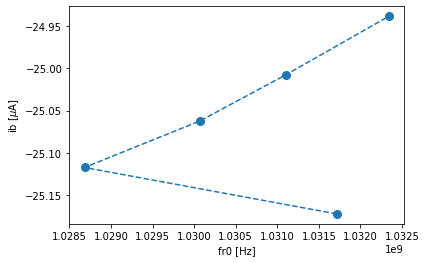

In [10]:
dss.ib.head(5).plot(marker='o', markersize=8, linestyle='--')

Seems like we can simply cut values below -25.15 uA:

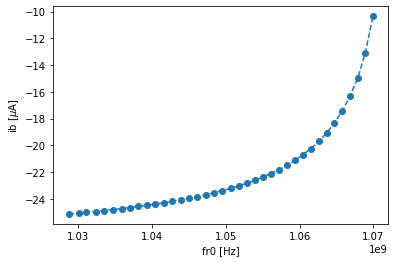

In [11]:
dssc = dss.where(dss.ib >= -25.15, drop=True)
dssc.ib.plot(marker='o', markersize=6, linestyle='--')

We can see that ib is now single valued function of fr for this cut.  Let's proceed with selecting the paramap at 1.06 GHz.

In [12]:
pds106 = dssc.sel(fr0=1.06e9, method='nearest')
display(pds106)

<xarray.Dataset>
Dimensions:   (detuning: 45, ppump: 196)
Coordinates:
  * detuning  (detuning) float64 -2.2 -2.1 -2.0 -1.9 -1.8 ... 1.9 2.0 2.1 2.2
  * ppump     (ppump) float64 -20.0 -19.8 -19.6 -19.4 ... 18.4 18.6 18.8 19.0
    ib        float64 -20.71
    fr0       float64 1.06e+09
    bw0       float64 2.388e+06
    fp        (detuning) float64 2.116e+09 2.116e+09 ... 2.126e+09 2.126e+09
Data variables:
    g1        (ppump, detuning) float64 1.38 -0.6116 0.7082 ... -10.97 -13.74
    g2        (ppump, detuning) float64 0.6198 -0.2981 2.315 ... -5.782 -4.588
    g1m       (ppump, detuning) float64 nan nan nan nan nan ... nan nan nan nan
    g2m       (ppump, detuning) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    fo1:      1000.0
    fo2:      100000.0
    ps:       -20.0

Now that we selected only one paramap corresponding to a single ib, the dimension of the dataset reduced to 2.  We can proceed with plotting the variables of interest, namely g1 and g2.

Text(0.5, 0.98, 'ib = -20.70777188091935, fr0 = 1060437904.02832...')

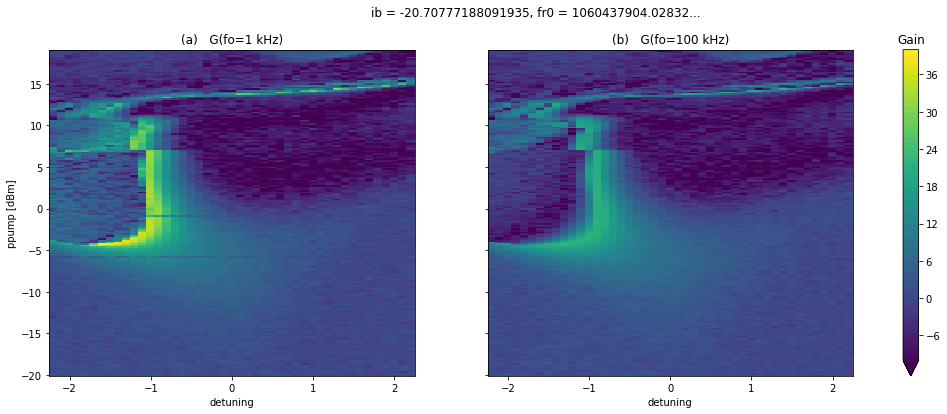

In [13]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(18,6))
g1p = pds106.g1.plot.pcolormesh(add_colorbar=False, vmin=-10, vmax=40, levels=51, ax=ax1)
g2p = pds106.g2.plot.pcolormesh(add_colorbar=False, vmin=-10, vmax=40, levels=51, ax=ax2)
cbar = fig.colorbar(g2p, ax=[ax1, ax2])
cbar.ax.set_title('Gain')
ax2.set_ylabel('')
title = ax1.get_title()
ax1.set_title('(a)   G(fo=1 kHz)')
ax2.set_title('(b)   G(fo=100 kHz)')
fig.suptitle(title)

The figure (a) is a plot of `g1` whereas the (b) is for `g2`.

We can see figure (a) contains some strange line cutting the horizontal axis around -6 and -1 dBm pump powers.  For this dataset, this is confirmed to be related to the pump signal generator, and has nothing to do with the JPA itself.  

## 3. Data Cuts and Selection
Using `pds106`, we can do some simple cuts to select data points.

Before doing that, let's define a function to do the side-by-side plotting done in the previous step.

In [14]:
def sidebyside(
    pds: xr.Dataset, isgray: bool = False, axs=None,
    vmin=None, vmax=None, levels=None, cbar: bool=True):
    """Args:
    pds:  Dataset with detuning and ppump as only dimensions.
    isgray:  Grayscale colormap is used if `True`.  
    """
    cmap = 'gray' if isgray else None
    if axs is None:
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(18,6))
    else:
        fig = plt.gcf()
        ax1, ax2 = axs
        
    if vmin is None:
        vmin = -10
    if vmax is None:
        vmax = 40
    if levels is None:
        levels = 51
        
    g1p = pds.g1.plot.pcolormesh(add_colorbar=False, vmin=vmin, vmax=vmax, levels=levels, ax=ax1, cmap=cmap)
    g2p = pds.g2.plot.pcolormesh(add_colorbar=False, vmin=vmin, vmax=vmax, levels=levels, ax=ax2, cmap=cmap)
    
    if cbar:
        cbar = fig.colorbar(g2p, ax=[ax1, ax2])
        cbar.ax.set_title('Gain')
    ax2.set_ylabel('')
    title = ax1.get_title()
    ax1.set_title('(a)   G(fo=1 kHz)')
    ax2.set_title('(b)   G(fo=100 kHz)')
    fig.suptitle(title)
    return fig, [ax1, ax2]

### 3.1 Gain Cuts

Biasing the JPA to have gain greater than 30 dB tend to have too little bandwidth to be of use.  Also, biasing with gains less than 10 dB fail to suppress the noise coming from the later stages.  Let's start by performing a cut for data points satisfying $ 10 \leq g_1 \leq 30 $

Text(0.5, 0.98, 'ZOOMED')

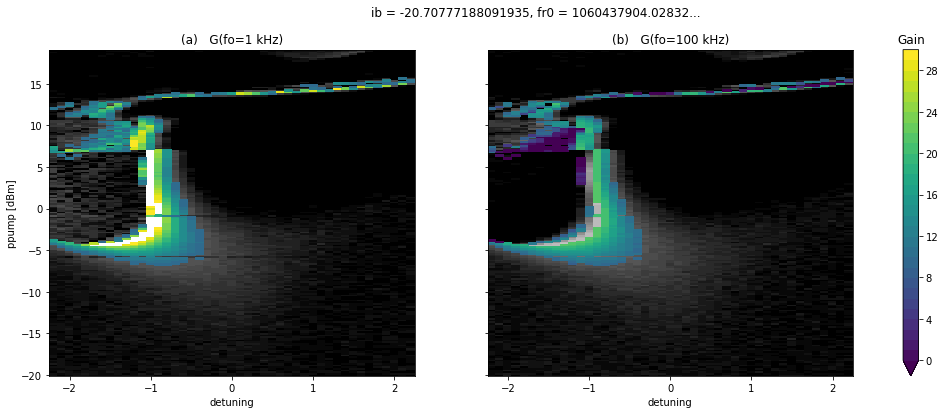

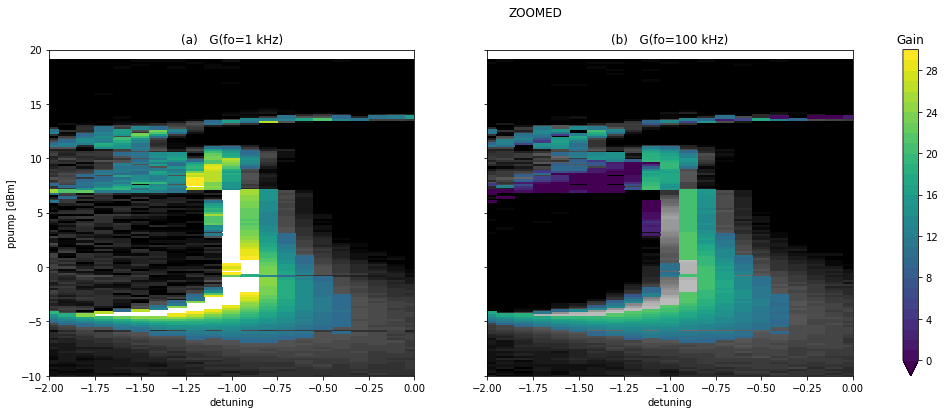

In [15]:
pds106_g = pds106.where(pds106.g1 > 10).where(pds106.g1 <= 30)
fig, axs = sidebyside(pds106, True, vmin=0, vmax=30, levels=31, cbar=False)
sidebyside(pds106_g, False, axs, vmin=0, vmax=30, levels=31)

fig, axs = sidebyside(pds106, True, vmin=0, vmax=30, levels=31, cbar=False)
sidebyside(pds106_g, False, axs, vmin=0, vmax=30, levels=31)
axs[0].set_xlim((-2, 0))
axs[0].set_ylim((-10, 20))
axs[1].set_xlim((-2, 0))
axs[1].set_ylim((-10, 20))
fig.suptitle('ZOOMED')

From the zoomed figures, we can see that some selected points have close to 0 gain at 100 kHz.  This indicates either those points have a very sharp gain, or behave oscilatory.  Either way, these points are unusable, and focusing those regions with the assumption of linearity will provide garbage results.

Among many, two ways to get rid of these points are:

1. Perform a second cut using $ \verb|g2| $ rather than $ \verb|g1| $.
2. Perform a second cut using $ \verb|gdif = g1 - g2| $.

I will use the second way to select the points satisfying the condition $ g_1 - g_2 \le 3 \mathrm{dB}$.  This choise has the benefit that the resulting points will have the meaning "the points for which the bandwidth is at least 200 kHz".  This of course means that we define the bandwidth as the frequency difference between the points where the gain reduces 3 dB of it's maximum value.

Text(0.5, 0.98, 'ZOOMED')

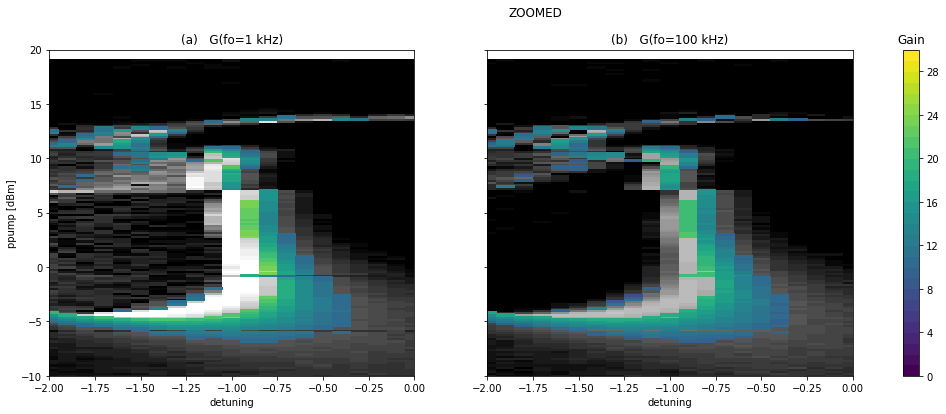

In [16]:
pds106_g2 = pds106_g.where(pds106.g1 - pds106.g2 <= 3)

fig, axs = sidebyside(pds106, True, vmin=0, vmax=30, levels=31, cbar=False)
sidebyside(pds106_g2, False, axs, vmin=0, vmax=30, levels=31)
axs[0].set_xlim((-2, 0))
axs[0].set_ylim((-10, 20))
axs[1].set_xlim((-2, 0))
axs[1].set_ylim((-10, 20))
fig.suptitle('ZOOMED')

We can see that we got rid of all the bias points which have vanishing gains at 100 kHz.   Another way to see is to look at the histograms rather than the 2d plots.

Text(0.5, 1.0, 'g1+gdif cut')

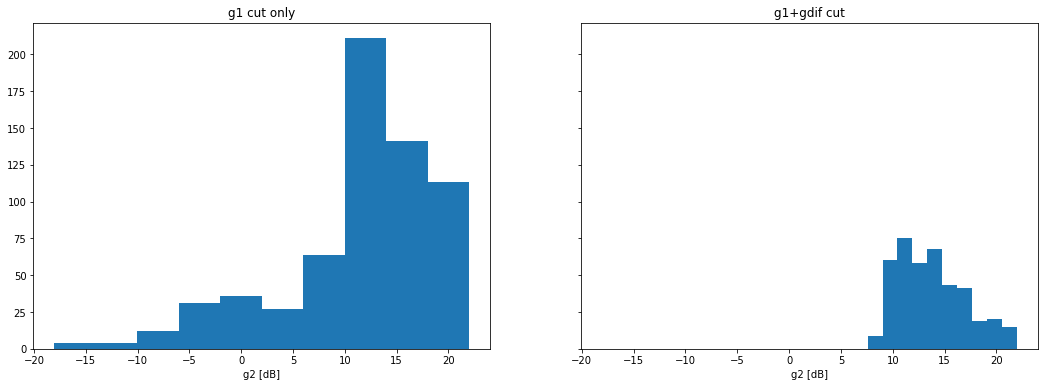

In [17]:
fig, axs = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(18, 6))

pds106_g.g2.plot.hist(ax=axs[0])
pds106_g2.g2.plot.hist(ax=axs[1])

axs[0].set_title('g1 cut only')
axs[1].set_title('g1+gdif cut')

### 3.2 Pump Power Selection
We can further apply more cuts based on our assumptions about the usability of the data points.  We can safely cut out data points with pump powers greater than 7 dB, based on how they look in the figures.  This kind of cut is difficult to perform systematically as different paramaps usually have different structure based in $ i_b $.

(<Figure size 1296x432 with 3 Axes>,
  <matplotlib.axes._subplots.AxesSubplot at 0x27d61b006c8>])

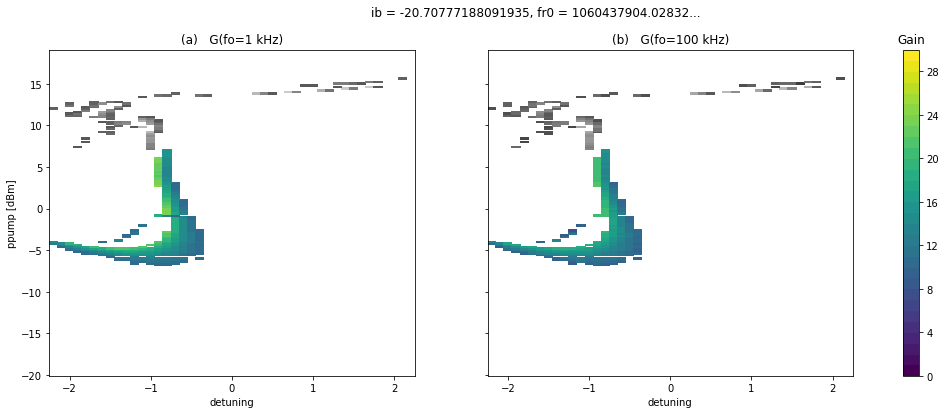

In [18]:
pds106_g2p = pds106_g2.where(pds106.ppump <= 7)

fig, axs = sidebyside(pds106_g2, True, vmin=0, vmax=30, levels=31, cbar=False)
sidebyside(pds106_g2p, False, axs, vmin=0, vmax=30, levels=31)

From the figures we can distinguish an "outer region" where the bias points are much more likely to be useful.  There are a few leftover parts in the inner region which are most likely to be useless and the result of a fluke during paramap measurements.  Cutting these kind of points out without affecting nearby regions is outside the scope of this note.  

### 3.3 Flattening & Saving the Data Points
In order to create a table of bias points, we shall flatten the dataset and get rid of all the "empty" points.  There are different ways to do this using xarray.  I found stacking the dimensions explicitly to do this to be concise:

In [19]:
stacked = pds106_g2p.stack(wp=['detuning', 'ppump']).dropna(dim='wp', how='all')
display(stacked)

<xarray.Dataset>
Dimensions:   (wp: 303)
Coordinates:
    ib        float64 -20.71
    fr0       float64 1.06e+09
    bw0       float64 2.388e+06
    fp        (wp) float64 2.116e+09 2.116e+09 2.116e+09 ... 2.12e+09 2.12e+09
  * wp        (wp) MultiIndex
  - detuning  (wp) float64 -2.2 -2.2 -2.1 -2.1 -2.1 ... -0.4 -0.4 -0.4 -0.4 -0.4
  - ppump     (wp) float64 -4.2 -4.0 -4.6 -4.4 -4.2 ... -3.4 -3.2 -3.0 -2.8 -2.6
Data variables:
    g1        (wp) float64 12.35 14.37 10.78 12.64 ... 10.32 10.99 10.37 10.46
    g2        (wp) float64 10.81 13.49 9.724 11.71 ... 10.49 10.57 10.19 10.52
    g1m       (wp) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
    g2m       (wp) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Attributes:
    fo1:      1000.0
    fo2:      100000.0
    ps:       -20.0

Note how we reduced the total amount of data points:

In [190]:
print(f"Original: {pds106.g1.size} | After Cuts: {stacked.g1.size}")

Original: 8820 | After Cuts: 303


Now we can save these bias points to be used in an `snrscan.py` measurement (noise temperature measurement script using SNR & Spectral comparison, located under `groundcontrol/scripts/`)

In [20]:
# Remove the indexing coordinate 'wp'
# This effectively finishes the conversion of the multi-dimensional
# dataset into a simple "Table".
table = stacked.reset_index('wp')

# Convert to a pandas dataframe, which makes it easy to save as csv
df = table.to_dataframe()

# As of now, the snrscan requires the input working points 
# to be saved in a CSV file with the columns ordered as follows.
order = ['ib', 'detuning', 'ppump', 'fr0', 'bw0', 'g1', 'g2', 'g1m', 'g2m', 'fp']
df_reord = df[order]

# detuning is shortened to det, ppump is shortened to pp (in snrscan)
df_rnm = df_reord.rename({'detuning': 'det', 'ppump': 'pp'})

df_rnm.to_csv('data/paramap_analysis_basic_cuts.csv')

# 4. Conclusion
In this notebook I tried to show basic analysis of paramap `.nc` dataset using `xarray` formalisms.  The ideas presented here were already implemented in a commandline program `extractwp.py` in `groundcontrol/scripts/analysis`.   Here is the output of `extractwp.py -h`:

    usage: extractwp.py [-h] [-c1 G1MIN G1MAX G2MIN] [-c2 G1MIN G1MAX G2DIF] [-d DMIN DMAX] [-p PMIN PMAX] [-f FR0] path

    Extract working points from paramap based on given conditions. If '-d' option is given it takes precedence over '-c'.

    positional arguments:
      path                  Path to paramap netcdf file.

    optional arguments:
      -h, --help            show this help message and exit
      -c1 G1MIN G1MAX G2MIN
                            Perform a cut by defining a region with 'G1MIN <= g1 <= G1MAX, g2 >= G2MIN' where g1 is the gain at 1st frequency offset and g2 is the gain at the 2nd frequency offset.
      -c2 G1MIN G1MAX G2DIF
                            Perform a cut by defining a region with 'G1MIN <= g1 <= G1MAX, g1-g2 >= G2DIF' where g1 is the gain at 1st frequency offset and g2 is the gain at the 2nd frequency offset.
      -d DMIN DMAX          Perform a cut by defining a detuning region with 'DMIN <= detuning <= DMAX'
      -p PMIN PMAX          Perform a cut by defining a pump power region with 'PMIN <= ppump <= PMAX'
      -f FR0                fr0 selection, nearest value is used.
      
      
A very similar analysis implemented `unorganized/pumpsweepselect.py` does the same things, but  selects a single detuning bin.  It's superseded by `crossfrcut.py` found in `groundcontrol/scripts/analysis`, but it may be still useful to look at if one is interested, it's a short script.

`crossfrcut.py`, does the cuts accross all $ i_b $, digitizes gain values according to given intervals, and selects points with minimum pump powers for each defined interval.  Following is it's help output:

    usage: crossfrcut.py [-h] [-c G1MIN G1MAX G2DIF] [-d DMIN DMAX] [-p PMIN PMAX] [--plot] [--out OUT] [--gain-edges GAIN_EDGES [GAIN_EDGES ...]] path

    To perform a cut over different fr

    positional arguments:
      path                  Path to paramap netcdf file.

    optional arguments:
      -h, --help            show this help message and exit
      -c G1MIN G1MAX G2DIF  Perform a cut by defining a region with 'G1MIN <= g1 <= G1MAX, g1-g2 >= G2DIF' where g1 is the gain at 1st frequency offset and g2 is the gain at the 2nd frequency offset.
      -d DMIN DMAX          Perform a cut by defining a detuning region with 'DMIN <= detuning <= DMAX'
      -p PMIN PMAX          Perform a cut by defining a pump power region with 'PMIN <= ppump <= PMAX'
      --plot
      --out OUT, -o OUT     Output csv filename. Defaults to 'out.csv'
      --gain-edges GAIN_EDGES [GAIN_EDGES ...]
                            A set of monotone increasing gain values to be used asintervals. The intervals are used to group the dataset andaggregate by selecting the minimum pump power data in each group.


In the end, `extractwp.py` will be deprecated, and `crossfrcut.py` will be expanded to have more cutting & plotting options.  The reader is strongly encouraged to check the analysis scripts `extractwp.py`, `crossfrcut.py`.